<a href="https://colab.research.google.com/github/matari18/ml/blob/main/TS_ML_aggs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование временных рядов при помощи машинного обучения

Что обсудим:

1. Генерация признаков
2. Обучение модели регрессии на сгенерированных признаках

## Предобработка временного ряда

Импорт библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

Будем работать с данными о ежемесячной средней зарплате сотрудников некоторой компании.

In [ ]:
ts_wage = pd.read_csv(
    'https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/monthly_wage.csv',
    sep=';',
    decimal='.',
    parse_dates=True,
    index_col='Month'
    )

ts_wage.head()

,Real wage
Month,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


In [ ]:
ts_wage.shape

(289, 1)

Посмотрим как ведет себя временной ряд

<Axes: xlabel='Month'>

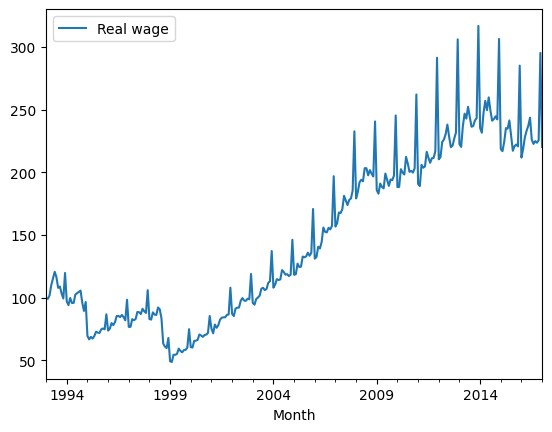

In [ ]:
ts_wage.plot()

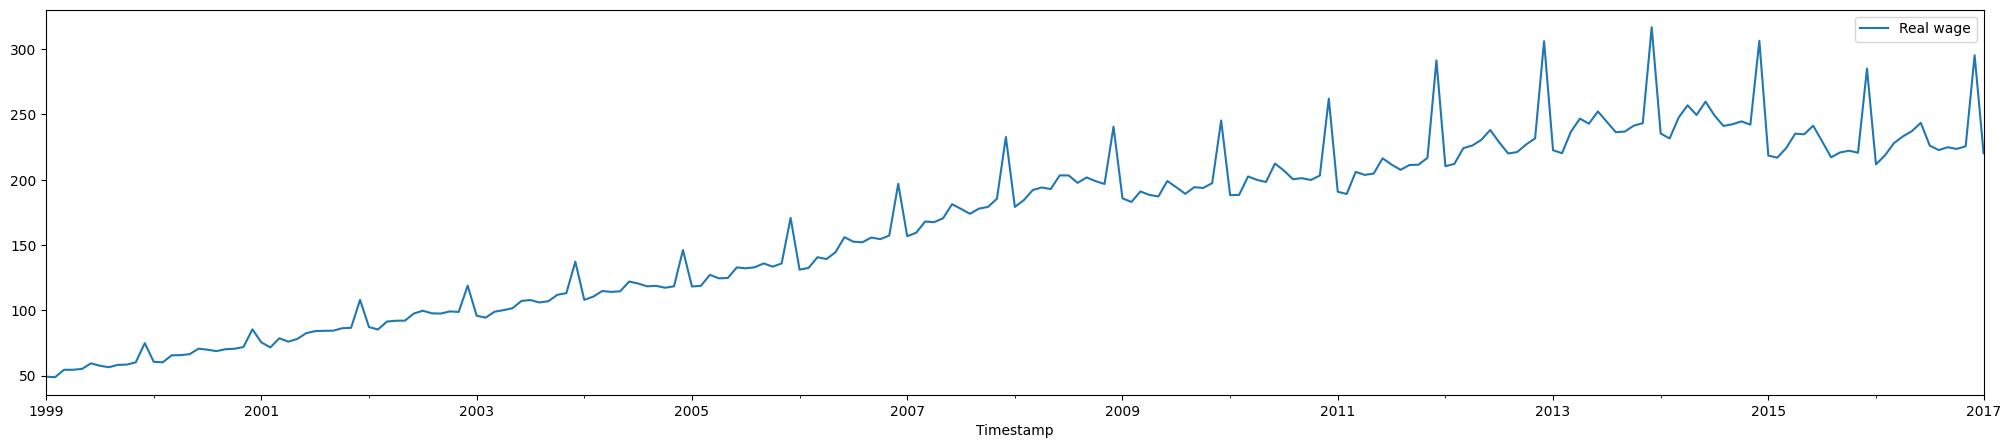

In [ ]:
ts_wage.index.names=['Timestamp']
ts_wage = ts_wage.sort_index()

ts_wage = ts_wage.loc['01.01.1999':'01.01.2017']
ts_wage.plot(figsize=(25,5));

## Машинное обучение для прогнозирования временных рядов

### Что будет признаками для прогноза временного ряда?

### Лаговые признаки (lags)

Это значения ряда в предыдущие моменты времени.

Например, чтобы предсказать курс доллара сегодня ($y_t$), мы можем использовать значения курса доллара за последнюю неделю:

$$y_{t-1},y_{t-2},...,y_{t-7}.$$

Это и будут признаки.

In [ ]:
ts_wage['Real wage'].shift(1)

Timestamp
1999-01-01       NaN
1999-02-01     49.22
1999-03-01     48.77
1999-04-01     54.48
1999-05-01     54.48
               ...  
2016-09-01    222.70
2016-10-01    224.90
2016-11-01    223.60
2016-12-01    225.60
2017-01-01    295.30
Name: Real wage, Length: 217, dtype: float64

In [ ]:
for i in range(1, 8):
    ts_wage[f"lag_{i}"] = ts_wage['Real wage'].shift(i)

In [ ]:
ts_wage.head()

,Real wage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Timestamp,,,,,,,,
1999-01-01,49.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-02-01,48.77,49.22,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-01,54.48,48.77,49.22,NaN,NaN,NaN,NaN,NaN
1999-04-01,54.48,54.48,48.77,49.22,NaN,NaN,NaN,NaN
1999-05-01,55.13,54.48,54.48,48.77,49.22,NaN,NaN,NaN


In [ ]:
ts_wage.dropna(inplace=True)

ts_wage.head()

,Real wage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Timestamp,,,,,,,,
1999-08-01,56.45,57.54,59.38,55.13,54.48,54.48,48.77,49.22
1999-09-01,58.20,56.45,57.54,59.38,55.13,54.48,54.48,48.77
1999-10-01,58.43,58.20,56.45,57.54,59.38,55.13,54.48,54.48
1999-11-01,60.18,58.43,58.20,56.45,57.54,59.38,55.13,54.48
1999-12-01,74.87,60.18,58.43,58.20,56.45,57.54,59.38,55.13


### Разбиение на train и test для временных рядов

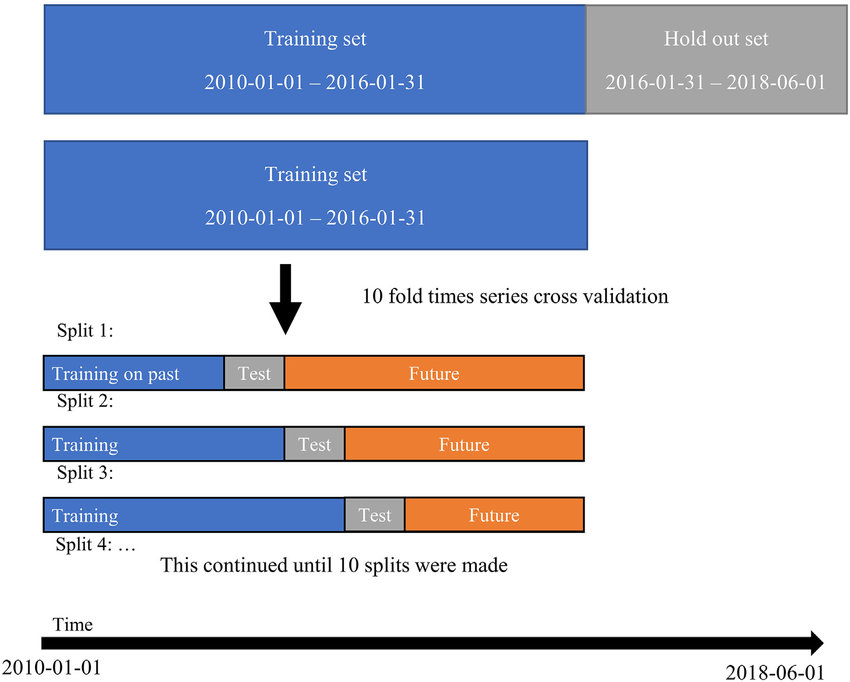

Разобъем данные на тренировочную и тестовую части.

In [ ]:
Train = ts_wage.loc['01.01.1999':'31.12.2014']
Test = ts_wage.loc['01.01.2015':'01.01.2017']

Train.shape, Test.shape

((185, 8), (25, 8))

In [ ]:
X_train = Train.drop('Real wage', axis=1)
y_train = Train['Real wage']

X_test = Test.drop('Real wage', axis=1)
y_test = Test['Real wage']

## Прогнозирование временных рядов

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

Обучим линейную регрессию:

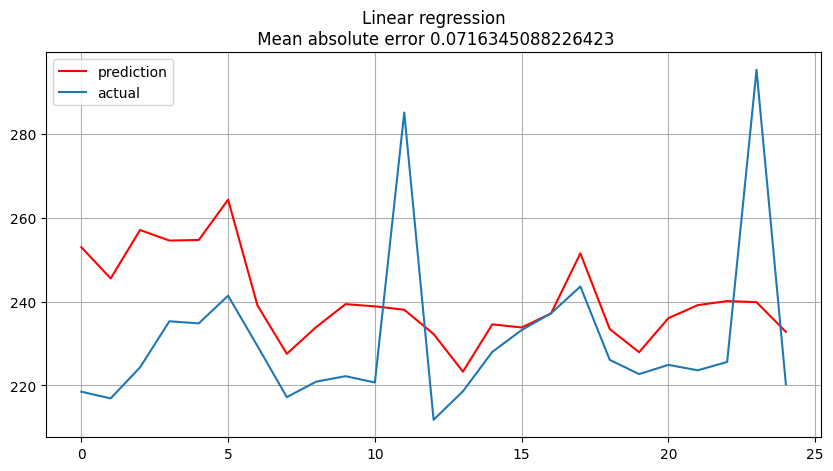

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_percentage_error(preds, y_test)}");

## Агрегированные признаки

Какие еще признаки можно использовать?

Напишем функцию, которая возвращает словарь, где ключами являются уникальные категории признака `cat_feature`, а значениями - средние по `real_feature`.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Давайте достанем из дат отдельно номер месяца и год и добавим их как новые признаки.

In [ ]:
data = ts_wage.copy()

ts_wage["month"] = ts_wage.index.month

ts_wage.head()

,Real wage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month
Timestamp,,,,,,,,,
1999-08-01,56.45,57.54,59.38,55.13,54.48,54.48,48.77,49.22,8
1999-09-01,58.20,56.45,57.54,59.38,55.13,54.48,54.48,48.77,9
1999-10-01,58.43,58.20,56.45,57.54,59.38,55.13,54.48,54.48,10
1999-11-01,60.18,58.43,58.20,56.45,57.54,59.38,55.13,54.48,11
1999-12-01,74.87,60.18,58.43,58.20,56.45,57.54,59.38,55.13,12


Вычислим среднее значение целевой переменной по месяцам и по годам:

In [ ]:
code_mean(ts_wage, "month", "Real wage")

{1: 160.89666666666665,
 2: 157.46941176470588,
 3: 166.93176470588236,
 4: 168.45529411764704,
 5: 168.85764705882352,
 6: 177.4335294117647,
 7: 172.83529411764704,
 8: 162.39277777777775,
 9: 164.47777777777776,
 10: 165.20222222222222,
 11: 166.95555555555555,
 12: 212.23611111111111}

Можно это удобно обернуть все шаги в функцию и заменить исходные признаки на их среднее как один из вариантов препроцессинга, а также - добавить значения целевой переменной с разной длиной временного лага.

В функции мы:

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [ ]:
def preprocess_data(data, lag_start=1, lag_end=8, date_cut='31.12.2014'):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['Real wage'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.loc[:date_cut], "month", "Real wage").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:date_cut].drop(["Real wage"], axis=1)
    y_train = data.loc[:date_cut]["Real wage"]
    X_test = data.loc[date_cut:].drop(["Real wage"], axis=1)
    y_test = data.loc[date_cut:]["Real wage"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(ts_wage)

X_train.shape, X_test.shape

((178, 8), (25, 8))

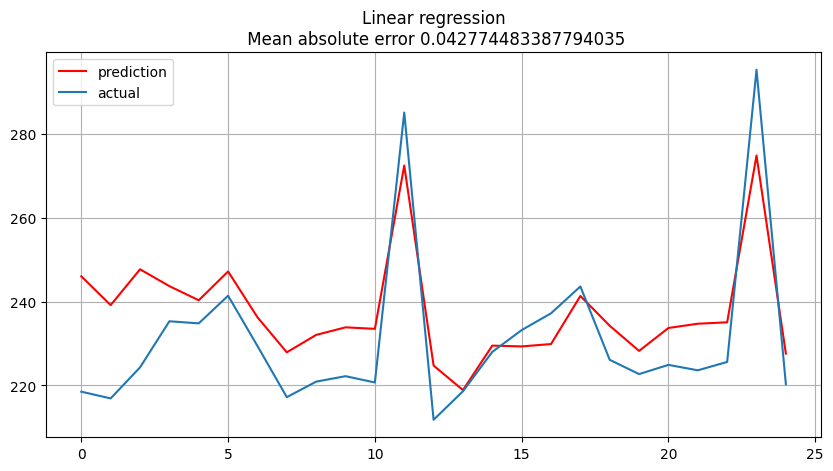

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_percentage_error(preds, y_test)}");